In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import torch_geometric.transforms as T
from torch_geometric.nn import Node2Vec
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid, KarateClub

In [4]:
from torch_geometric.datasets import QM7b, QM9

# Load the QM7b dataset
dataset_qm7b = QM7b(root='./data/QM7b')
# Load the QM9 dataset
dataset_qm9 = QM9(root='./data/QM9')

Processing...
Done!
Extracting data\QM9\raw\qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


In [5]:
print(f'Number of graphs: {len(dataset_qm7b)}')
print(f'Number of graphs: {len(dataset_qm9)}')

Number of graphs: 7211
Number of graphs: 130831


Data(edge_index=[2, 144], edge_attr=[144], y=[1, 14], num_nodes=12)
tensor([[-1.1243e+03,  1.5291e+01,  2.1215e-01, -1.2160e+01,  3.0640e+00,
          9.8595e+00,  1.1550e+01, -2.8213e+00, -7.8663e+00, -6.0400e-02,
         -1.0206e+01,  9.6200e-01,  6.8718e+00,  7.3503e+00]])
tensor([ 0.5000,  2.8910,  0.2965,  0.2966,  0.1393,  1.5834,  1.4626,  0.1794,
         0.1224,  0.1386,  0.2122,  0.9095,  2.8910, 36.8581,  2.8860,  2.8798,
         1.1347, 10.3644, 12.4716,  1.2070,  0.9095,  1.1295,  1.4739,  7.4983,
         0.2965,  2.8860,  0.5000,  0.2977,  0.1672,  1.2438,  1.4560,  0.1451,
         0.1386,  0.2009,  0.2109,  1.1295,  0.2966,  2.8798,  0.2977,  0.5000,
         0.2033,  1.5251,  1.4588,  0.2079,  0.1393,  0.1672,  0.1719,  1.1348,
         0.1393,  1.1347,  0.1672,  0.2033,  0.5000,  1.5251,  1.4587,  0.2079,
         0.2966,  0.2977,  0.1719,  2.8798,  1.5834, 10.3644,  1.2438,  1.5251,
         1.5251, 73.5167, 17.6286,  4.3431,  1.5834,  1.2438,  2.1074, 10.3642,
 

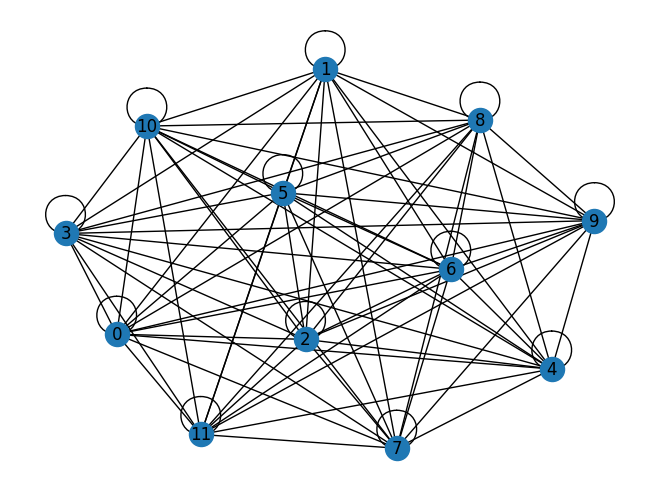

In [8]:
i = 45

print(dataset_qm7b[i])
print(dataset_qm7b[i].y)
print(dataset_qm7b[i].edge_attr)

g = to_networkx(dataset_qm7b[i], to_undirected=True)
nx.draw(g, with_labels=True)

In [9]:
combined_graph = nx.Graph()
node_offset = 0
graph_to_nodes = {}  # Track which nodes belong to which molecule

for i in range(len(dataset_qm7b)):
    g = to_networkx(dataset_qm7b[i], to_undirected=True)
    graph_to_nodes[i] = list(range(node_offset, node_offset + len(g.nodes())))

    # Add nodes with offset
    for node in g.nodes():
        combined_graph.add_node(node + node_offset, **g.nodes[node])

    # Add edges with offset
    for u, v, data in g.edges(data=True):
        combined_graph.add_edge(u + node_offset, v + node_offset, **data)

    node_offset += len(g.nodes())


In [10]:
edge_index = torch.tensor(list(combined_graph.edges()), dtype=torch.long).t().contiguous()
x = torch.tensor(list(combined_graph.nodes()), dtype=torch.float)
print(edge_index.shape)
print(x.shape)

torch.Size([2, 938773])
torch.Size([111180])


In [86]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

edge_index = torch.tensor(list(combined_graph.edges()), dtype=torch.long).t().contiguous().to(device)
x = torch.tensor(list(combined_graph.nodes()), dtype=torch.float).to(device)

model = Node2Vec(edge_index=edge_index, embedding_dim=10, walk_length=10, context_size=5,
                 walks_per_node=10, num_negative_samples=1, p=0.6, q=3, sparse=False).to(device)
loader = model.loader(batch_size=128, shuffle=True, num_workers=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [75]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [ ]:
for epoch in range(1, 10):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')